Training Baseline (Random Init, 50 Epochs, Batch 32)...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Pre-trained (Autoencoder, 50 Epochs, Batch 32)...
Training Baseline (Random Init, 100 Epochs, Batch 32)...
Training Baseline (Random Init, 50 Epochs, Batch 64)...


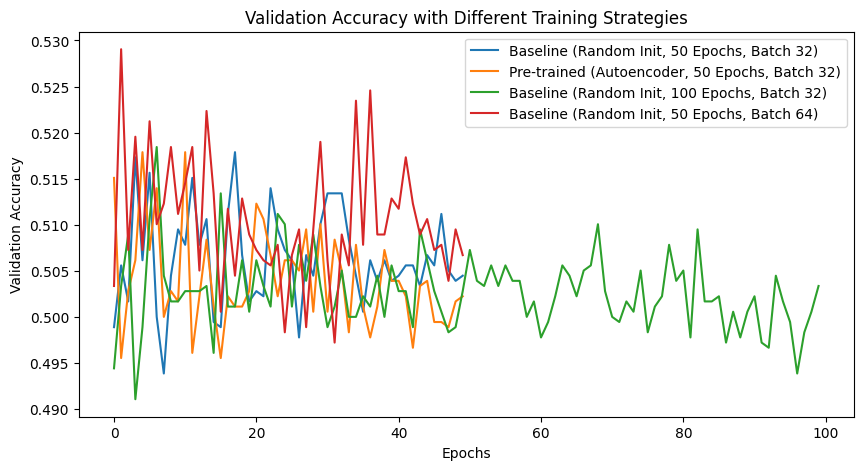

Final Accuracy (Baseline (Random Init, 50 Epochs, Batch 32)): 0.5045
Final Accuracy (Pre-trained (Autoencoder, 50 Epochs, Batch 32)): 0.5022
Final Accuracy (Baseline (Random Init, 100 Epochs, Batch 32)): 0.5034
Final Accuracy (Baseline (Random Init, 50 Epochs, Batch 64)): 0.5067


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Load and preprocess dataset
data = pd.read_csv("CC GENERAL.csv")
data = data.drop(columns=['CUST_ID'])  # Remove non-numeric ID column
data.fillna(data.mean(), inplace=True)  # Handle missing values

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Dummy target variable (Binary classification for experiment)
y = np.random.randint(0, 2, size=(data.shape[0], 1))

# Split data
X_train, X_test, y_train, y_test = train_test_split(data_scaled, y, test_size=0.2, random_state=42)

# Function to create a model
def create_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Output layer
    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Scenarios to test
configurations = {
    "Baseline (Random Init, 50 Epochs, Batch 32)": {"pretrain": False, "epochs": 50, "batch_size": 32},
    "Pre-trained (Autoencoder, 50 Epochs, Batch 32)": {"pretrain": True, "epochs": 50, "batch_size": 32},
    "Baseline (Random Init, 100 Epochs, Batch 32)": {"pretrain": False, "epochs": 100, "batch_size": 32},
    "Baseline (Random Init, 50 Epochs, Batch 64)": {"pretrain": False, "epochs": 50, "batch_size": 64}
}

# Pre-training using an autoencoder (unsupervised learning phase)
def pretrain_autoencoder(X_train):
    autoencoder = Sequential([
        Dense(64, activation='relu', input_dim=X_train.shape[1]),
        Dense(32, activation='relu'),
        Dense(64, activation='relu'),
        Dense(X_train.shape[1], activation='linear')  # Output layer to reconstruct input
    ])
    autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    autoencoder.fit(X_train, X_train, epochs=30, batch_size=32, verbose=0)  # Train to reconstruct data
    pretrained_weights = autoencoder.layers[0].get_weights()  # Extract weights from first layer
    return pretrained_weights

# Store results
results = {}

# Train and evaluate models for different configurations
for config_name, params in configurations.items():
    print(f"Training {config_name}...")
    model = create_model()

    # Apply pre-trained weights if applicable
    if params["pretrain"]:
        pretrained_weights = pretrain_autoencoder(X_train)
        model.layers[0].set_weights(pretrained_weights)

    # Train the model
    history = model.fit(X_train, y_train, epochs=params["epochs"], batch_size=params["batch_size"],
                        validation_data=(X_test, y_test), verbose=0)

    results[config_name] = history.history

# Plot accuracy comparison
plt.figure(figsize=(10, 5))
for config in results.keys():
    plt.plot(results[config]['val_accuracy'], label=config)
plt.title("Validation Accuracy with Different Training Strategies")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

# Print final validation accuracy
for config, history in results.items():
    print(f"Final Accuracy ({config}): {history['val_accuracy'][-1]:.4f}")


# Explanation of the code

The provided code performs customer segmentation using a neural network while analyzing the effects of pre-training, number of epochs, and batch size. It begins by loading and preprocessing the dataset, removing the customer ID column and handling missing values by filling them with the mean. The data is then standardized using StandardScaler to improve neural network performance. A binary target variable is randomly generated for experimentation purposes, and the dataset is split into training and testing sets. The core function, create_model(), defines a simple feedforward neural network with three layers: an input layer , a hidden layer , and an output layer. The model is compiled using the Adam optimizer and binary cross-entropy loss function. The experiment tests multiple configurations: (1) a baseline model with randomly initialized weights, (2) a pre-trained model using an autoencoder for feature learning, (3) models trained with different epochs (50 vs. 100), and (4) different batch sizes (32 vs. 64). The autoencoder-based pre-training initializes the first layer's weights with meaningful patterns before fine-tuning on the classification task. Each model is trained and evaluated on the test data, with validation accuracy plotted for comparison. Finally, the script outputs the final accuracy of each configuration, allowing an analysis of how pre-training, epochs, and batch sizes impact model performance.